## 30 баллов

Рассмотрим задачу минимизации кусочно-линейной функции на сфере
\begin{equation}
\begin{split}
&\min_{x\in R^n} \left \{ f(x) = \max_{1 \leq i \leq k} (a_i^Tx -b_i) \right \}\\
&\text{subject to}\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}



# Часть 1


### a) Постройте сглаженную версию целевой функции $f_{\mu}(x)$ с параметром гладкости $\mu$


$$
f(x) = \max_{1 \leq i \leq k} f_i(x) = \max_{u \in \Delta^k = \{u \in \mathbb{R}^k~|~u_i \geqslant 0,~ \sum_{i}{u_i} = 1\}} \sum_{i}{u_if_i(x)}
$$
$$
f(x) = \max_{u \in \mathbb{R}^k} \{\sum_{i}{u_i(a_i^Tx - b_i)}~|~u_i \geqslant 0,~\sum_{i}{u_i} = 1\}
$$
$$
d_2 = \sum_{i}{u_i\ln{u_i}} + \ln{k}
$$
$$
f_{\mu}(x) = \max_{u \in \Delta^k}\{\sum_{i}{u_i(a_i^Tx - b_i)} - \mu \sum_{i}{u_i\ln{u_i}} + \mu \ln{k}\}
$$
- Выпишем Лагранжиан для данной задачи на поиск максимума:
$$
L(u, \nu, \lambda) = -\sum_{i}{u_i(a_i^Tx - b_i)} + \mu\sum_{i}{u_i\ln{u_i}} + \sum_{i}{\nu_i u_i} + \lambda(\sum_{i}{(u_i - 1)}
$$
- Выпишем условия ККТ:
$$
\nabla_{u_i}{L} = 0 \Leftrightarrow -(a_i^Tx - b_i) + \mu(1 + \ln{u_i^*}) + \nu_i^* + \lambda^* = 0~\forall~i
$$
$$
u_i^* \geqslant 0,~~~ \sum_{i}{u_i^*} = 1,~~~ u_i^*\nu_i^* = 0,~~~ \nu_i^* \geqslant 0,~~~ \forall~i
$$
$$
u_i^* = \exp{\frac{a_i^Tx - b_i - \nu_i^* - \lambda^* - \mu}{\mu}} > 0 \Rightarrow \nu_i^* = 0
$$
$$
u_i^* = \exp{\frac{a_i^Tx - b_i - \lambda^* - \mu}{\mu}}
$$
$$
\sum_{i}{u_i^*} = 1 \Leftrightarrow \exp{\frac{- \lambda^* - \mu}{\mu}}\sum_{i}{\exp{\frac{a_i^Tx - b_i}{\mu}}} = 1
$$
$$
\exp{\frac{- \lambda^* - \mu}{\mu}} = \frac{1}{\sum_{i}{\exp{\frac{a_i^Tx - b_i}{\mu}}}}
$$
$$
u_i^* = \frac{\exp{\frac{a_i^Tx - b_i}{\mu}}}{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}}}
$$
$$
f_{\mu}(x) = \sum_{i}{\frac{\exp{\frac{a_i^Tx - b_i}{\mu}}}{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}}}(a_i^Tx - b_i)} - \mu\sum_{i}{\frac{\exp{\frac{a_i^Tx - b_i}{\mu}}}{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}}}}(\frac{a_i^T - b_i}{\mu} - \ln{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}})} + \mu\ln{k} = 
$$
$$
= \mu\sum_{i}{\frac{\exp{\frac{a_i^Tx - b_i}{\mu}}}{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}}}}\ln{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}}} + \mu\ln{k} = \mu\ln{\sum_{j}{\exp{\frac{a_j^Tx - b_j}{\mu}}}} + \mu\ln{k}
$$

### б) Реализуйте быстрый градиентный метод из статьи (Nesterov, 2005)

https://www.math.ucdavis.edu/~sqma/MAT258A_Files/Nesterov-2005.pdf

In [168]:
# use sigma=1

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import math
from numpy import linalg as LA
import time

def sum_exp(a, b, xk, mu):
    return np.sum(np.exp((a @ xk - b) / mu))

def compute_f_mu(a, b, mu, k, xk, summ_exp):
    return mu * math.log(summ_exp) + mu * math.log(k)

def gradient(a, b, mu, summ_exp, xk, n, k):
    summ = np.zeros(n)
    for i in range(k):
        summ += a[i] * math.exp(((a[i] @ xk - b[i]) / mu)[0])
    return summ / summ_exp

def compute_y_k(k, a, xk, grad, x0, L):
    condition = LA.norm(xk - x0 - grad / L) 
    if condition <= 1:
        return xk - grad / L
    else:
        return x0 + (xk - x0 - grad / L) / condition
    
def compute_z_k(n, array_grad, x0, L):
    summ = np.zeros(n)
    for i in range(len(array_grad)):
        summ += ((i + 1) / 2) * array_grad[i]
    condition = LA.norm(summ / L)
    if condition <= 1:
        return x0 - summ / L
    else:
        return x0 - (summ / L) / condition

def FGD_Nesterov(n, k, mu = 1, L = 1e5, NumOfIteration = 10000):
    array_grad = []
    array_f = []
    a = np.random.random((k, n))
    b = np.random.random((k, 1))
    x0 = np.random.random((n, 1))
    xk = x0
    array_time = []
    start_time = time.time()
    for Numiter in tqdm(range(NumOfIteration)):
        array_time.append(time.time() - start_time)
        summ_exp = sum_exp(a, b, xk, mu)
        grad = gradient(a, b, mu, summ_exp, xk, n, k)
        f_mu = compute_f_mu(a, b, mu, k, xk, summ_exp)
        array_grad.append(grad)
        array_f.append(f_mu)
        y_k = compute_y_k(k, a, xk, grad, x0, L)
        z_k = compute_z_k(n, array_grad, x0, L)
        xk = 2 / (Numiter + 3) * z_k + (Numiter + 1) / (Numiter + 3) * y_k
    return array_f, array_time


---



## Часть 2

Указанная выше задача может быть записана в эквивалентном виде

\begin{equation}
\begin{split}
&\min_{x\in R^n, t} t \\
&\text{subject to}\\
&a_i^Tx -b_i \leq t, \quad 1\leq i\leq k\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}

Для данной задачи напишите реализацию барьерного метода (включая метод Ньютона для внутренней операции)

Главы 9 и 11 в "Convex Optimization" Boyd

## Часть 3

Сгенерируйте искусственные (случайные) данные для тестирования алгоритмов.

Нам хочется сравнить эффективность методов для различной размерности задачи (то есть при росте $n$ и $k$). Ограничте время вычисления на каждый инстанс 1000с.

### а) Первый тест: $k=10$, $n_1=10$, $n_2 = 100$, $n_3=1000$, $n_4=10000$, $n_5=100000$ (5 сценариев).

### б) Второй тест: $n=10$, $k_1=10$, $k_2 = 100$, $k_3=1000$, $k_4=10000$, $k_5=100000$ (5 сценариев).

### в) Третий тест: [$n_1 = rand(10)$, $k_1 = rand(10)$], [$n_2 = rand(100)$, $k_2 = rand(100)$], [$n_3 = rand(1000)$, $k_3 = rand(1000)$], [$n_4 = rand(10000)$, $k_4 = rand(10000)$], [$n_5 = rand(100000)$, $k_5 = rand(100000)$] (5 сценариев).

В итоге у Вас должно получиться 15 сценариев (15 вариантов задачи). Можно взять $\sigma=1$, но $x_0$ сгенерируйте  случайно (не нужно делать его равным нуль-вектору).

Для каждого конкретного сценария постройте рисунок с графиками, описывающими работу алгоритма: по оси $x$ отложено время (работы алгоритма), а по оси $y$ значение целевой функции для каждого из алгоритмов.

Напишите свои выводы по сравнению алгоритмов (возможно, Вам захочется провести и другие тесты...)

### а) Первый тест: $k=10$, $n_1=10$, $n_2 = 100$, $n_3=1000$, $n_4=10000$, $n_5=100000$ (5 сценариев).

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-168-7805ef6321f3>:11: RuntimeWarning: overflow encountered in exp
  return np.sum(np.exp((a @ xk - b) / mu))
  0%|          | 0/2000 [00:00<?, ?it/s]


OverflowError: math range error

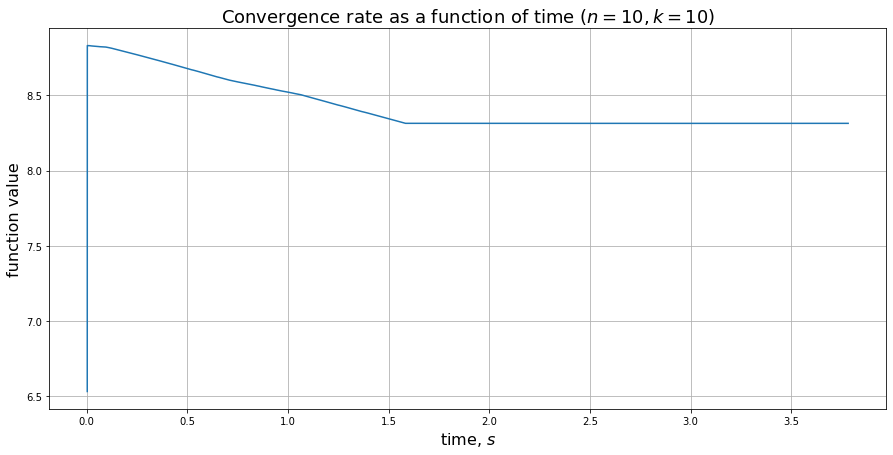

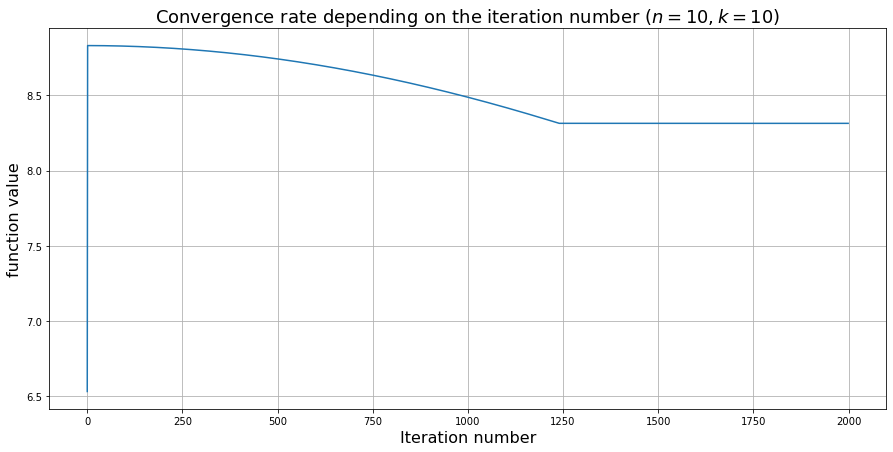

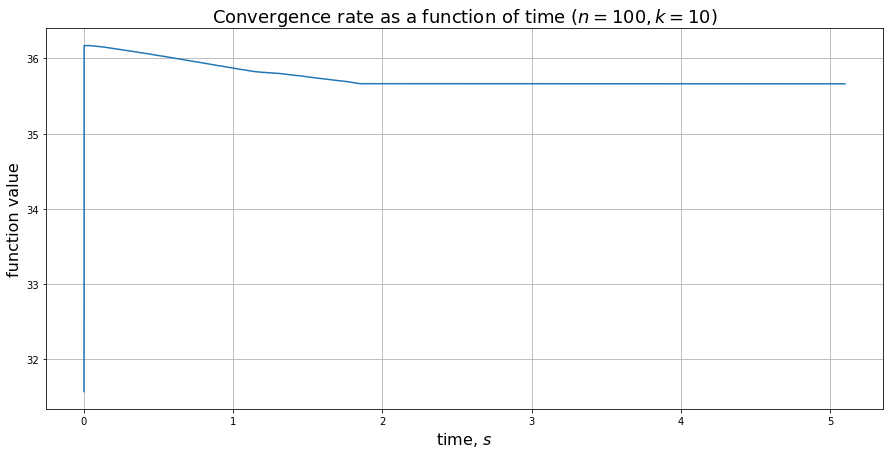

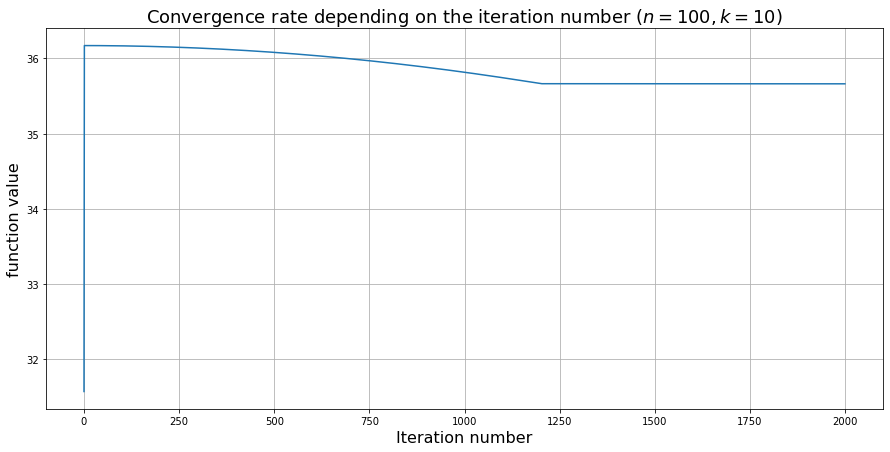

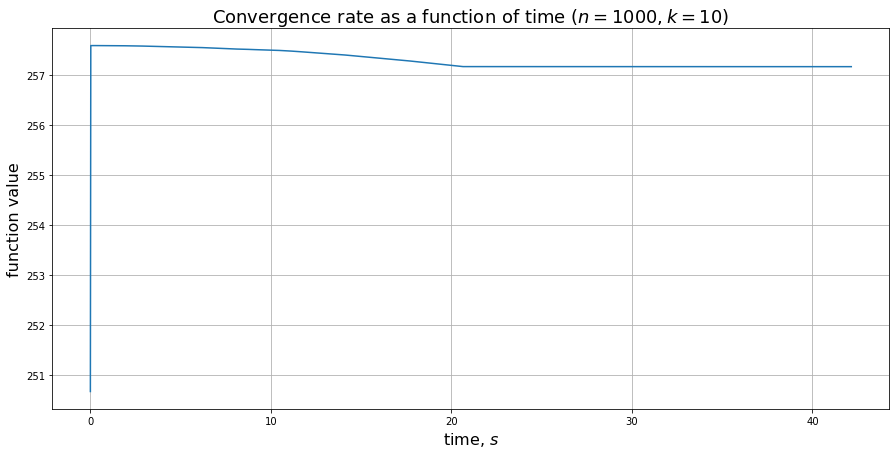

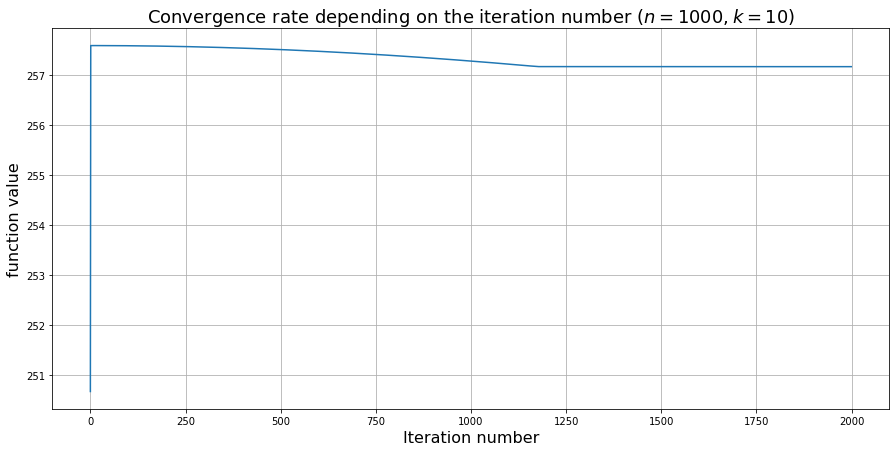

In [176]:
for num_script in range(5):
    k = 10
    n = 10 ** (num_script + 1)
    y, time_solve = FGD_Nesterov(n, k, mu = 1, L = 1e5, NumOfIteration = 2000)

    plt.figure(figsize=(15, 7))
    plt.title(r'Сonvergence rate as a function of time ($n = {}, k = {}$)'.format(n, k), fontsize=18)
    plt.xlabel(r'time, $s$', fontsize=16)
    plt.ylabel('function value', fontsize=16)
    plt.grid()
    plt.plot(time_solve, y, label = r'$f_{mu}$')

    plt.figure(figsize=(15, 7))
    plt.title(r'Convergence rate depending on the iteration number ($n = {}, k = {}$)'.format(n, k), fontsize=18)
    plt.xlabel('Iteration number', fontsize=16)
    plt.ylabel('function value', fontsize=16)
    plt.grid()
    plt.plot(range(2000), y, label = r'$f_{mu}$')

### б) Второй тест: $n=10$, $k_1=10$, $k_2 = 100$, $k_3=1000$, $k_4=10000$, $k_5=100000$ (5 сценариев).

  2%|▏         | 36/2000 [00:25<22:45,  1.44it/s]


KeyboardInterrupt: 

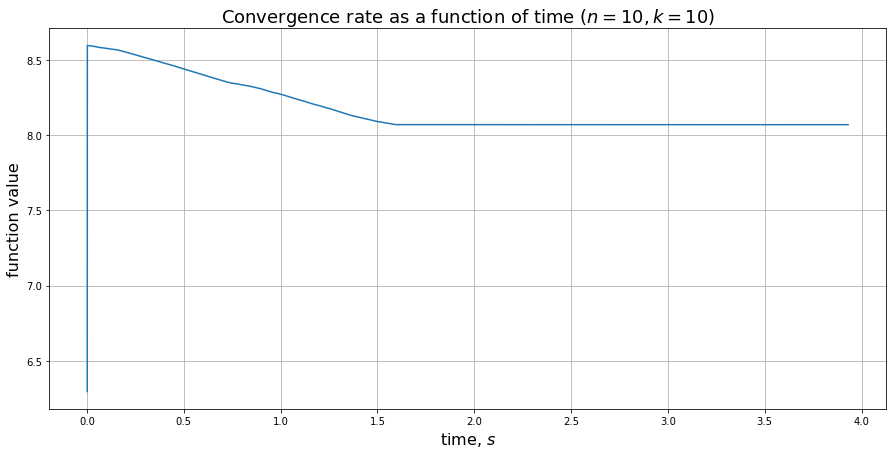

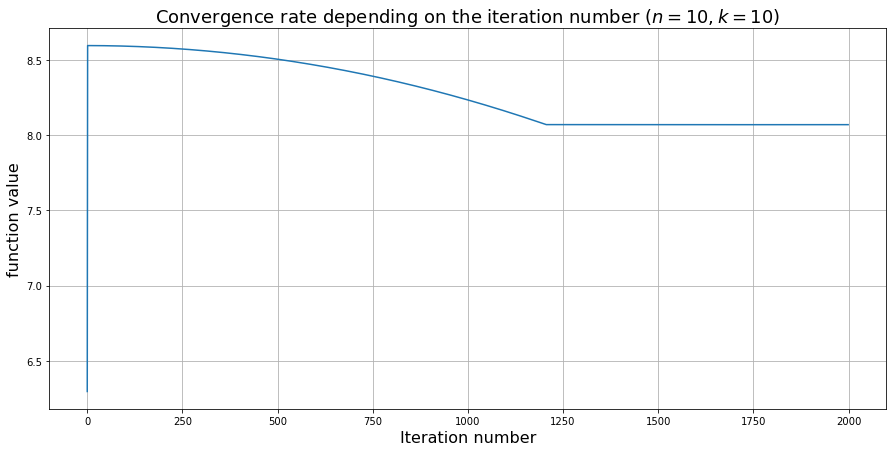

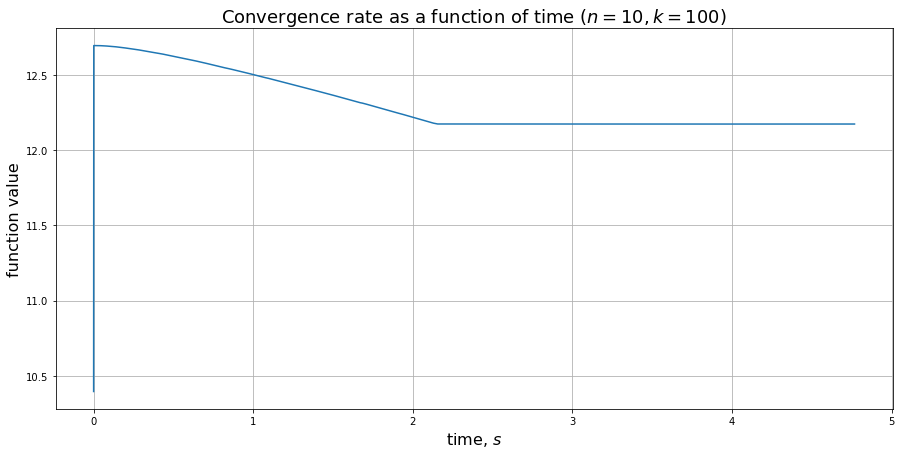

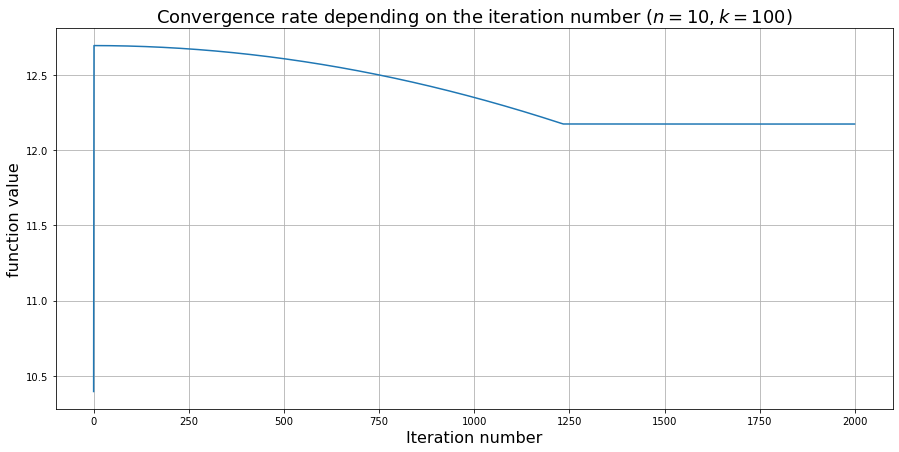

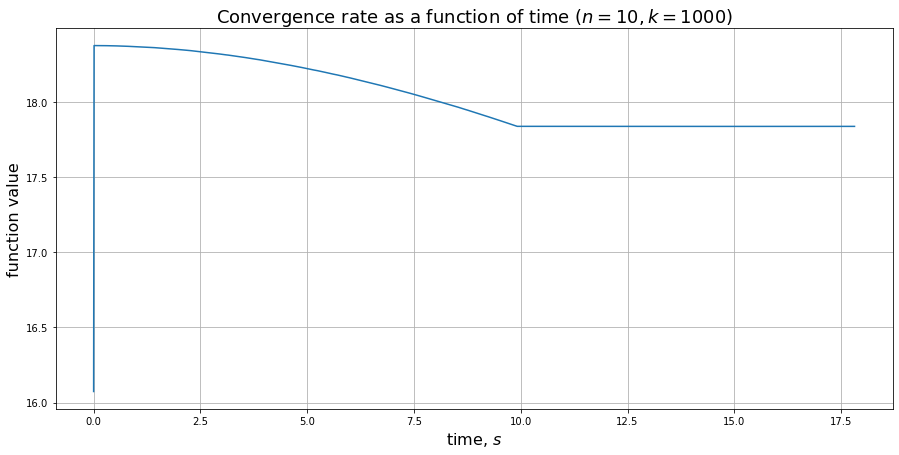

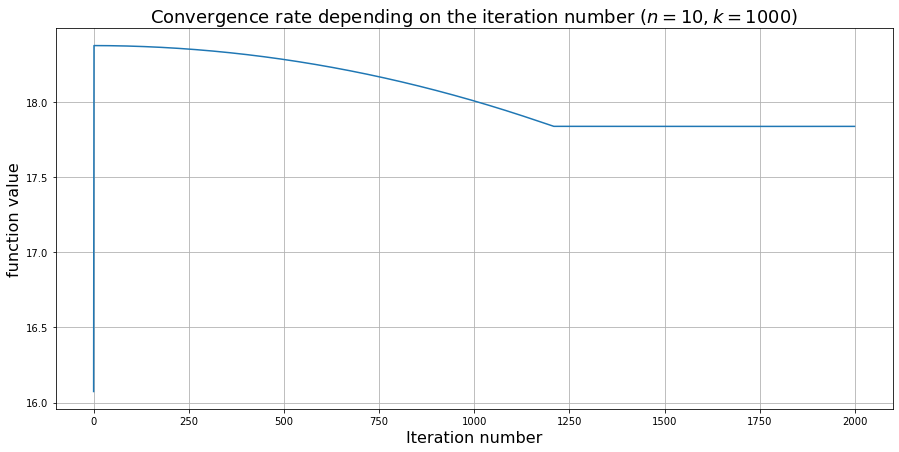

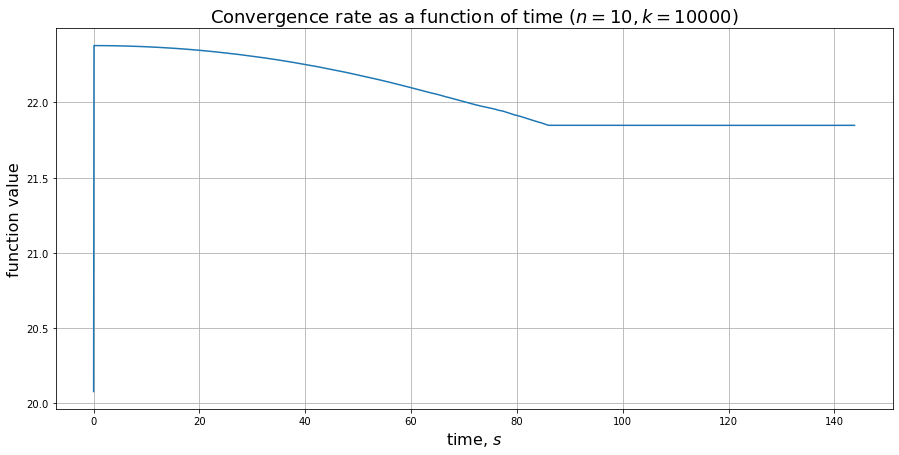

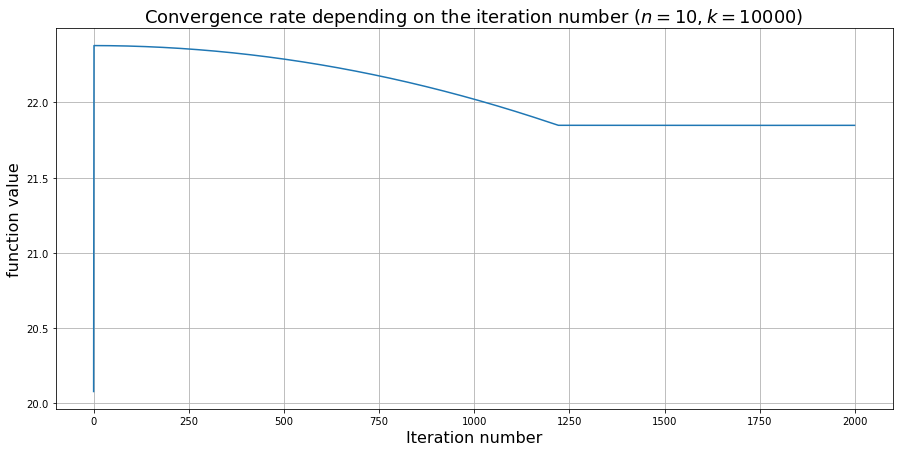

In [175]:
for num_script in range(5):
    n = 10
    k = 10 ** (num_script + 1)
    y, time_solve = FGD_Nesterov(n, k, mu = 1, L = 1e5, NumOfIteration = 2000)

    plt.figure(figsize=(15, 7))
    plt.title(r'Сonvergence rate as a function of time ($n = {}, k = {}$)'.format(n, k), fontsize=18)
    plt.xlabel(r'time, $s$', fontsize=16)
    plt.ylabel('function value', fontsize=16)
    plt.grid()
    plt.plot(time_solve, y, label = r'$f_{mu}$')

    plt.figure(figsize=(15, 7))
    plt.title(r'Convergence rate depending on the iteration number ($n = {}, k = {}$)'.format(n, k), fontsize=18)
    plt.xlabel('Iteration number', fontsize=16)
    plt.ylabel('function value', fontsize=16)
    plt.grid()
    plt.plot(range(2000), y, label = r'$f_{mu}$')

### в) Третий тест: [$n_1 = rand(10)$, $k_1 = rand(10)$], [$n_2 = rand(100)$, $k_2 = rand(100)$], [$n_3 = rand(1000)$, $k_3 = rand(1000)$], [$n_4 = rand(10000)$, $k_4 = rand(10000)$], [$n_5 = rand(100000)$, $k_5 = rand(100000)$] (5 сценариев).

  1%|          | 15/2000 [01:50<4:02:44,  7.34s/it]


KeyboardInterrupt: 

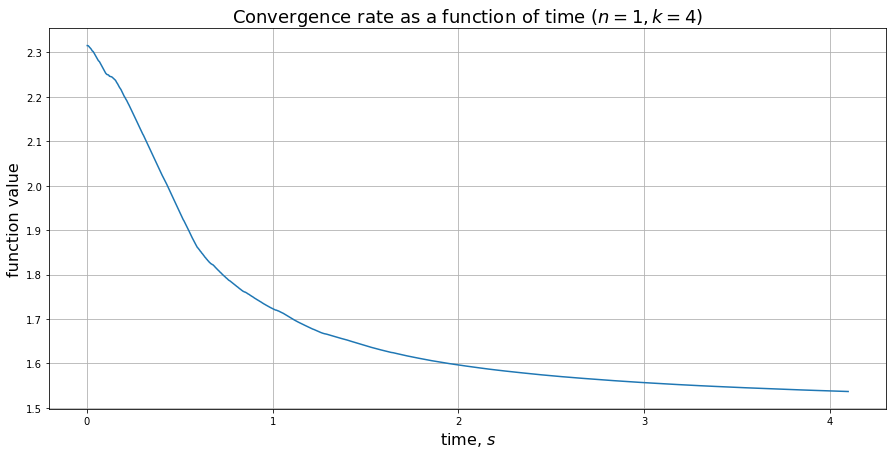

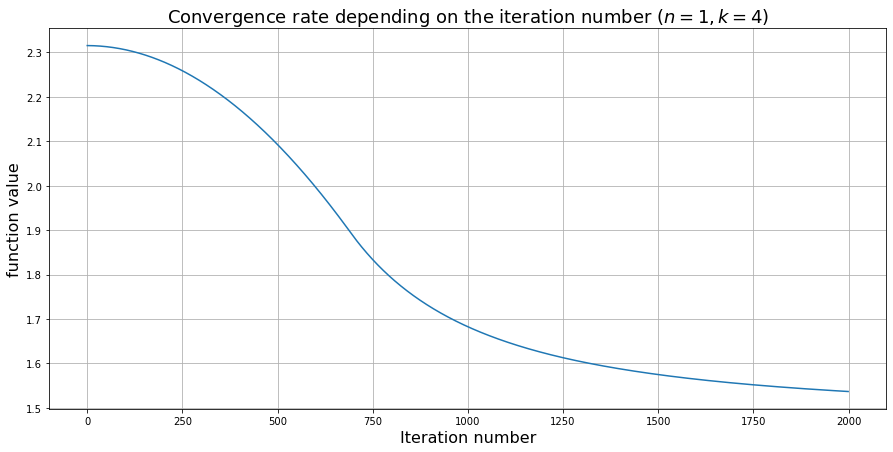

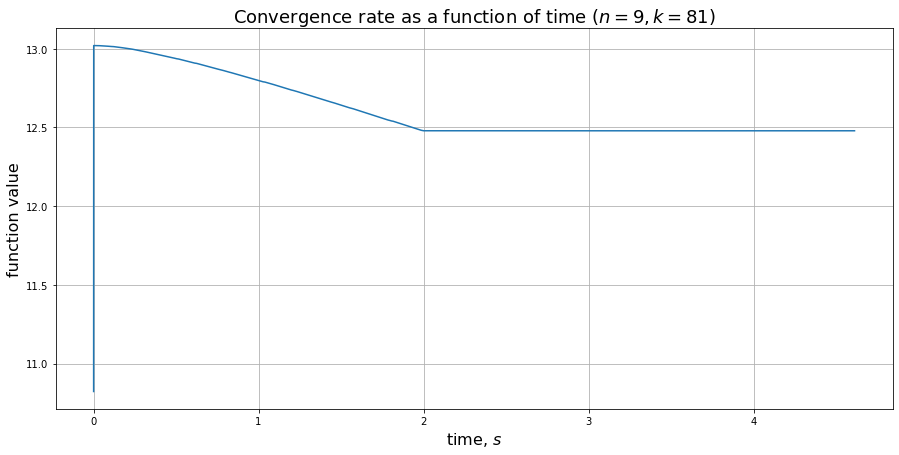

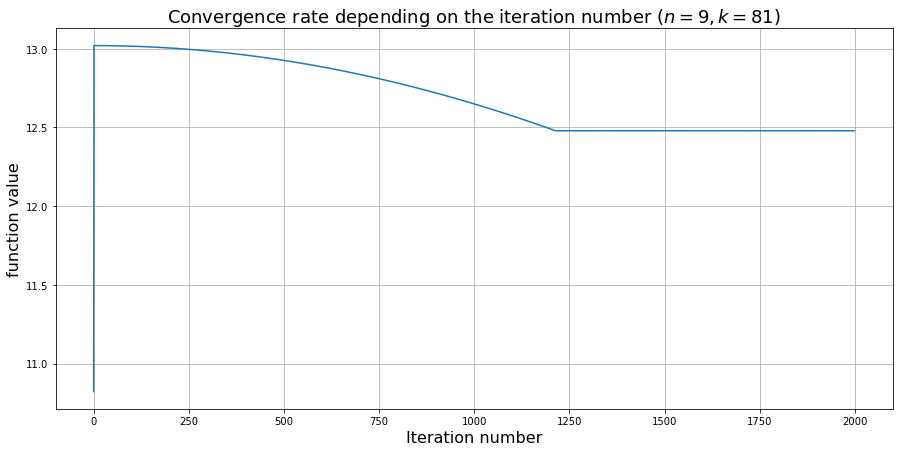

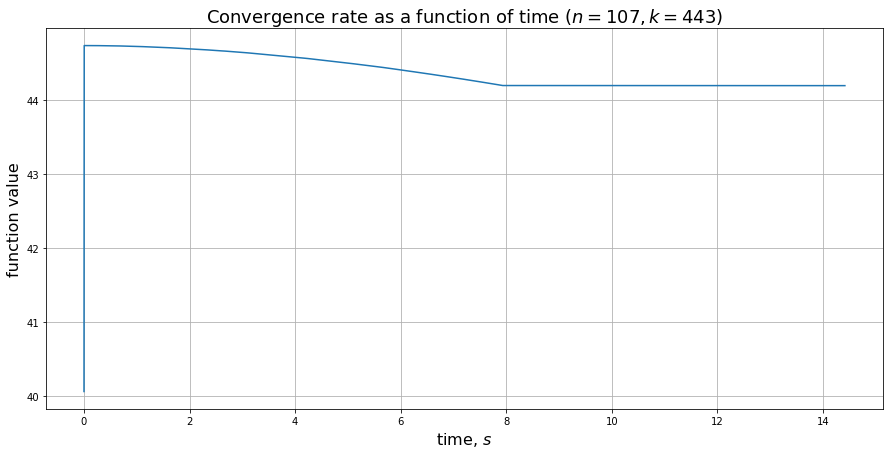

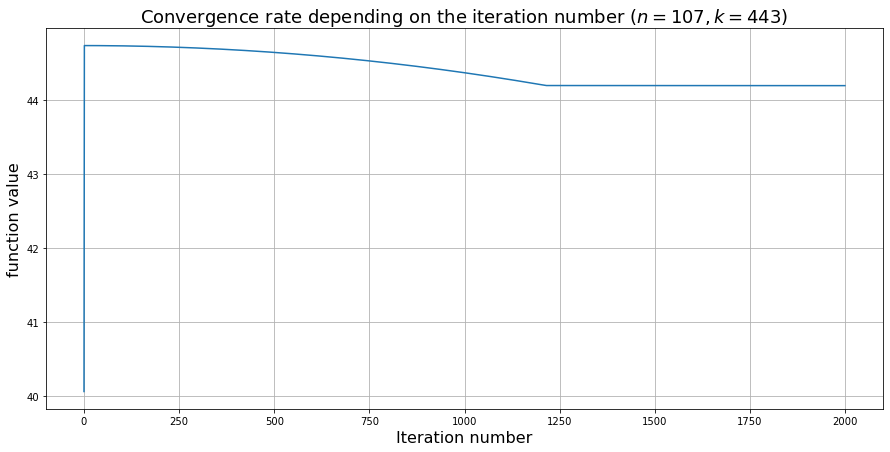

In [188]:
import random

for num_script in range(5):
    n = random.randint(1, 10 ** (num_script + 1))
    k = random.randint(1, 10 ** (num_script + 1))
    y, time_solve = FGD_Nesterov(n, k, mu = 1, L = 1e5, NumOfIteration = 2000)

    plt.figure(figsize=(15, 7))
    plt.title(r'Сonvergence rate as a function of time ($n = {}, k = {}$)'.format(n, k), fontsize=18)
    plt.xlabel(r'time, $s$', fontsize=16)
    plt.ylabel('function value', fontsize=16)
    plt.grid()
    plt.plot(time_solve, y, label = r'$f_{mu}$')

    plt.figure(figsize=(15, 7))
    plt.title(r'Convergence rate depending on the iteration number ($n = {}, k = {}$)'.format(n, k), fontsize=18)
    plt.xlabel('Iteration number', fontsize=16)
    plt.ylabel('function value', fontsize=16)
    plt.grid()
    plt.plot(range(2000), y, label = r'$f_{mu}$')